In [1]:
import mxnet as mx
from mxnet import ndarray as nd

from easydict import EasyDict as edict
import numpy as np
import os
from tqdm import tqdm
import skimage.io as io

import tensorflow as tf
import tensorflow.contrib.slim as slim
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))

### My versions of libraries

In [2]:
mx.__version__

'1.4.1'

In [3]:
tf.__version__

'1.13.1'

## Transformation of the MXNet model weights to NumPy

In [4]:
ctx = mx.gpu(0)
net = edict()
net.ctx = ctx
net.sym, net.arg_params, net.aux_params = mx.model.load_checkpoint('../../Matcher/models/model-r34-amf/model', 0)
all_layers = net.sym.get_internals()
net.sym = all_layers['fc1_output']
net.model = mx.mod.Module(symbol=net.sym, context=net.ctx, label_names = None)
net.model.bind(data_shapes=[('data', (2, 3, 112, 112))])
net.model.set_params(net.arg_params, net.aux_params)

In [5]:
stage1_length = len(set([x.name.split('_')[1] for x in net.sym.get_internals() if 'stage1' in x.name]))
stage2_length = len(set([x.name.split('_')[1] for x in net.sym.get_internals() if 'stage2' in x.name]))
stage3_length = len(set([x.name.split('_')[1] for x in net.sym.get_internals() if 'stage3' in x.name]))
stage4_length = len(set([x.name.split('_')[1] for x in net.sym.get_internals() if 'stage4' in x.name]))

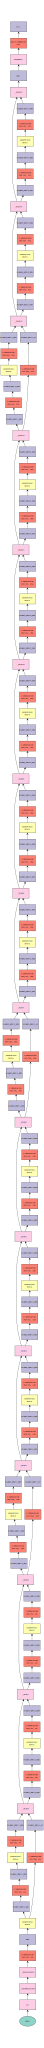

In [6]:
mx.viz.plot_network(net.sym)

In [7]:
try:
    os.mkdir('Weights')
except:
    pass
for i in tqdm(net.aux_params.keys()):
    np.save('Weights/'+i,net.aux_params[i].asnumpy())
for i in tqdm(net.arg_params.keys()):
    np.save('Weights/'+i,net.arg_params[i].asnumpy())

100%|██████████| 166/166 [00:00<00:00, 1132.65it/s]


### Testing batch to compare embeddings

In [8]:
img = io.imread('002.jpg')
img = np.transpose(img, [2,0,1])
b = np.random.uniform(0,255,size=(2,3,112,112))
b[0] = img

In [9]:
data = mx.nd.array(b)
db = mx.io.DataBatch(data=(data,))
net.model.forward(db, is_train=False)

## Common functions

In [10]:
def conv(x,name,size,inm,outm,stride=1,pad='SAME'):
    W = tf.get_variable('W_'+name,dtype=tf.float32,shape=[size,size,inm,outm],initializer=tf.constant_initializer(np.transpose(np.load('Weights/'+name+'_weight.npy'),[2,3,1,0])))
    return tf.nn.conv2d(x,W,[1,1,stride,stride],pad,name=name,data_format='NCHW')
def bn(x,name):
    return slim.batch_norm(x,center=True,scale=True,epsilon=2e-5,
                                 param_initializers={
                                     'beta':tf.constant_initializer(np.load('Weights/'+name+'_beta.npy')),
                                     'gamma':tf.constant_initializer(np.load('Weights/'+name+'_gamma.npy')),
                                     'moving_mean':tf.constant_initializer(np.load('Weights/'+name+'_moving_mean.npy')),
                                     'moving_variance':tf.constant_initializer(np.load('Weights/'+name+'_moving_var.npy'))},
                                  is_training=train,data_format='NCHW')
def lrelu(x,name,maps):
    a = tf.get_variable('a_'+name,dtype=tf.float32,shape=[maps],initializer=tf.constant_initializer(np.load('Weights/'+name+'_gamma.npy')))
    a = tf.reshape(a,[maps,1,1])
    return tf.nn.relu(x,name=name+'_pos')-tf.nn.relu(-x,name=name+'_neg')*a
def reduce_block(x,name,mapsin,mapsout):
    v1 = bn(x,name+'_bn1')
    v1 = conv(v1,name+'_conv1',3,mapsin,mapsout)
    v1 = bn(v1,name+'_bn2')
    v1 = lrelu(v1,name+'_relu1',mapsout)
    v1 = tf.pad(v1,[[0,0],[0, 0,], [1, 0],[1,0]])
    v1 = conv(v1,name+'_conv2',3,mapsout,mapsout,2,'VALID')
    v1 = bn(v1,name+'_bn3')
    x = conv(x,name+'_conv1sc',1,mapsin,mapsout,2)
    x = bn(x,name+'_sc')
    return x+v1
def block(x,name,maps):
    v1 = bn(x,name+'_bn1')
    v1 = conv(v1,name+'_conv1',3,maps,maps)
    v1 = bn(v1,name+'_bn2')
    v1 = lrelu(v1,name+'_relu1',maps)
    v1 = conv(v1,name+'_conv2',3,maps,maps)
    v1 = bn(v1,name+'_bn3')
    return x+v1

## TensorFlow twin 

In [11]:
x = tf.placeholder(tf.float32, [None,3,112,112], 'image_input')
train = tf.placeholder(tf.bool,name='training_mode')
prob = tf.placeholder(tf.float32,name='keep_prob')

In [12]:
conv0 = conv(x,'conv0',3,3,64)
bn0 = bn(conv0,'bn0')
relu0 = lrelu(bn0,'relu0',64)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
bl1 = reduce_block(relu0,'stage1_unit1',64,64)
for i in range(stage1_length-1):
    bl1 = block(bl1,'stage1_unit'+str(i+2),64)

In [14]:
bl2 = reduce_block(bl1,'stage2_unit1',64,128)
for i in range(stage2_length-1):
    bl2 = block(bl2,'stage2_unit'+str(i+2),128)

In [15]:
bl3 = reduce_block(bl2,'stage3_unit1',128,256)
for i in range(stage3_length-1):
    bl3 = block(bl3,'stage3_unit'+str(i+2),256)

In [16]:
bl4 = reduce_block(bl3,'stage4_unit1',256,512)
for i in range(stage4_length-1):
    bl4 = block(bl4,'stage4_unit'+str(i+2),512)

In [17]:
bn1 = bn(bl4,'bn1')
flat = tf.layers.flatten(bn1)
flat = tf.nn.dropout(flat,prob)
Wfc = tf.get_variable('W_fc',dtype=tf.float32,shape=[25088, 512],initializer=tf.constant_initializer(np.transpose(np.load('Weights/pre_fc1_weight.npy'),[1,0])))
fc = tf.matmul(flat, Wfc)
fc = bn(fc,'fc1')

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
sess.run(tf.global_variables_initializer())
print('L1 difference between embeddings:',np.max(np.abs(sess.run(fc,feed_dict={x:(b - 127.5)*0.0078125,prob:1.0,train:False})-net.model.get_outputs()[0].asnumpy())))

L1 difference between embeddings: 3.9339066e-06


In [19]:
x_norm = tf.nn.l2_normalize(fc,1,name='embedding')

In [20]:
graph = tf.get_default_graph()
input_graph_def = graph.as_graph_def()

In [21]:
output_node_names="embedding"
output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session
            input_graph_def, # input_graph_def is useful for retrieving the nodes 
            output_node_names.split(",")  
)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 275 variables.
INFO:tensorflow:Converted 275 variables to const ops.


In [22]:
output_graph="./r34.pb"
with tf.gfile.GFile(output_graph, "wb") as f:
    f.write(output_graph_def.SerializeToString())

## PB check

In [23]:
frozen_graph="./r34.pb"
with tf.gfile.GFile(frozen_graph, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as graph:
      tf.import_graph_def(graph_def,
                          input_map=None,
                          return_elements=None,
                          name="")

In [24]:
image_input = graph.get_tensor_by_name('image_input:0')
keep_prob = graph.get_tensor_by_name('keep_prob:0')
is_train = graph.get_tensor_by_name('training_mode:0')
embs = graph.get_tensor_by_name('embedding:0')

In [25]:
c = net.model.get_outputs()[0].asnumpy()
for i in range(2):
    c[i] = c[i]/np.sqrt(np.sum(c[i]**2))
sess = tf.Session(graph=graph)
print('L1 difference between normalized embeddings:',np.max(np.abs(sess.run(embs,feed_dict={image_input:(b - 127.5)*0.0078125,keep_prob:1.0,is_train:False})-c)))

L1 difference between normalized embeddings: 2.6077032e-07
